In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl

import am_sim as ams

In [2]:
from utilities.analyze_inference import best_par_in_df

# load inferred parameter set
search_df = pd.read_csv('inference_results/t_final_search_history.csv', index_col=0)
par = best_par_in_df(search_df)

### Panel A - asymptotic evolution

Successful convergence to the desired precision after 975 iterations


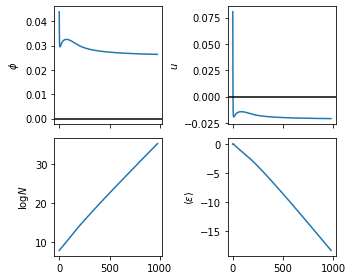

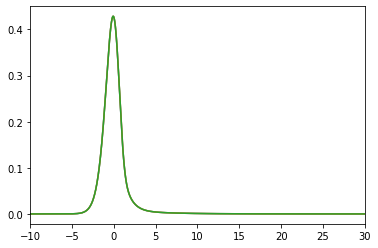

In [3]:
from utilities.asymptotic_evolution import evolve_pop_at_constant_C, asymptotic_phi_and_u

C_const = 30
T_skip = 10
T_save = 60

# simulate evolution with constant Ag concentratiojn
results = evolve_pop_at_constant_C(C_const, par, T_skip, T_save)

# extract results
t, N, avg_eps, distr_y, distr_x= [results[lab] for lab in ['t', 'N', 'avg_eps', 'distr_y', 'distr_x']]

# evaluate asymptotic growth rate and travelling wave speed
phi, u = asymptotic_phi_and_u(C_const, par, T_max=1000)

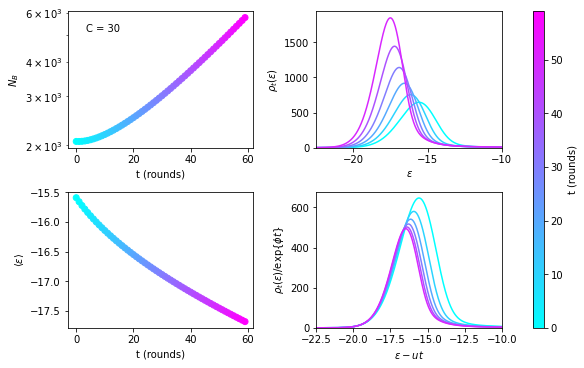

In [4]:
# setup figure
fig, ax = plt.subplots(2,2, figsize = (8,5), constrained_layout=True)

# setup colormap
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=t.min(), vmax=t.max())
mapp = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mapp.set_array(t)

# plot pop. size evolution
ax[0,0].scatter(t, N, color=cmap(norm(t)), zorder = 3) 

# plot pop. size evolution
ax[1,0].scatter(t, avg_eps, color=cmap(norm(t)), zorder = 3) 

plt_idsx = range(len(t))[::10]
for idx in plt_idsx:
    
    # evaluate population function
    pop_f = distr_y[idx] * N[idx]
    
    # plot evolution of population function
    ax[0,1].plot(distr_x, pop_f, c=cmap(norm(t[idx])))

    # evaluate rescaled population function
    shifted_x = distr_x - u * t[idx]
    rescaled_pop_f = pop_f / np.exp(phi * t[idx])
    
    # plot evolution of rescaled population function
    ax[1,1].plot(shifted_x, rescaled_pop_f, c=cmap(norm(t[idx])))

# set axes limits, scales and ticks
ax[0,0].set_yscale('log')
ax[0,1].set_ylim(bottom=0)
ax[1,1].set_ylim(bottom=0)
ax[0,1].set_xlim(-22.5, -10)
ax[1,1].set_xlim(-22.5, -10)
ax[0,1].set_xticks([-20, -15, -10])

# set labels
ax[0,0].set_xlabel('t (rounds)')
ax[0,0].set_ylabel(r'$N_B$')
ax[1,0].set_xlabel('t (rounds)')
ax[1,0].set_ylabel(r'$\langle \epsilon \rangle$')
ax[0,1].set_xlabel(r'$\epsilon$')
ax[0,1].set_ylabel(r'$\rho_t(\epsilon)$')
ax[1,1].set_xlabel(r'$\epsilon - u t$')
ax[1,1].set_ylabel(r'$\rho_t(\epsilon) / \exp \{\phi t\}$')

# write Ag concentration
ax[0,0].text(0.1, 0.85, f'C = {C_const}', transform=ax[0,0].transAxes)

# plot colorbar
plt.colorbar(mapp, ax=ax, label='t (rounds)', aspect=50.)

plt.savefig('figures/fig_4/panel_A.pdf')
plt.savefig('figures/fig_4/panel_A.svg')
plt.show()

### Panel B - pahse diagram

In [5]:
C_range = np.logspace(0,4,20)
T_max_sim = 10000

1.0
Successful convergence to the desired precision after 270 iterations


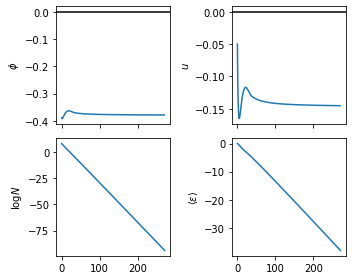

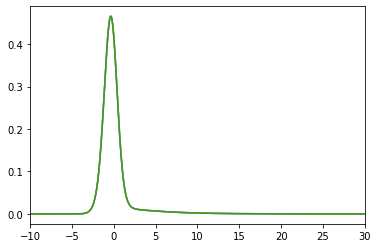

1.6237767391887217
Successful convergence to the desired precision after 312 iterations


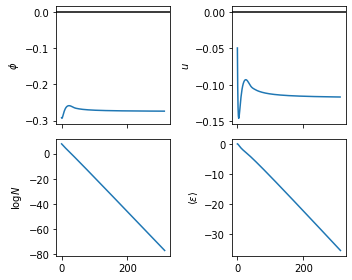

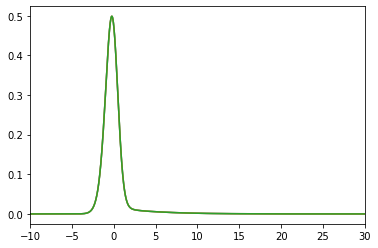

2.636650898730358
Successful convergence to the desired precision after 368 iterations


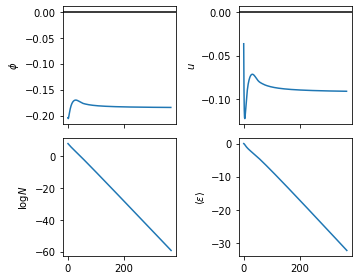

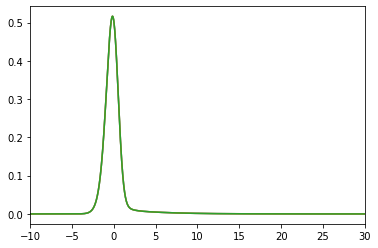

4.281332398719393
Successful convergence to the desired precision after 441 iterations


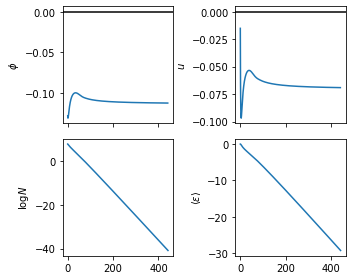

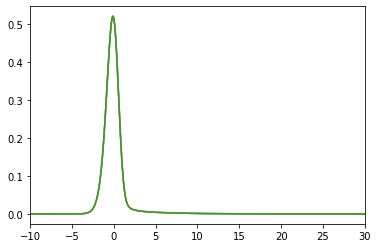

6.951927961775605
Successful convergence to the desired precision after 534 iterations


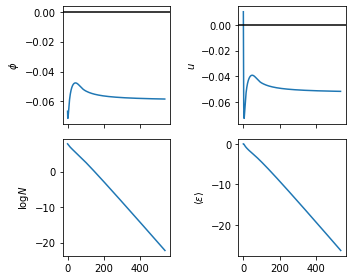

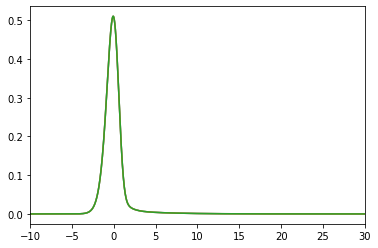

11.28837891684689
Successful convergence to the desired precision after 854 iterations


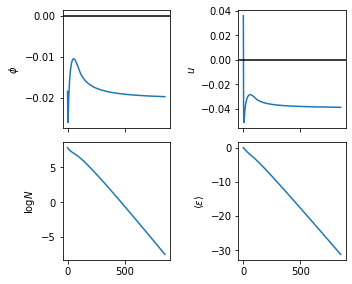

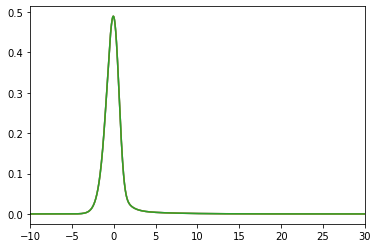

18.329807108324356
Successful convergence to the desired precision after 794 iterations


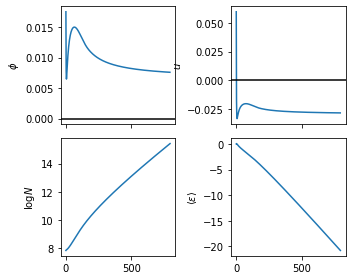

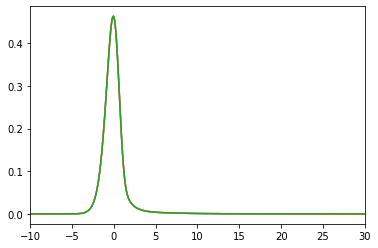

29.76351441631318
Successful convergence to the desired precision after 972 iterations


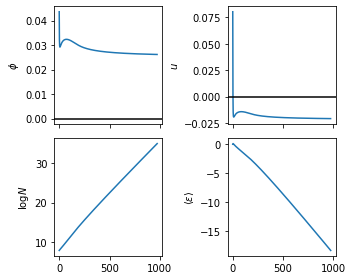

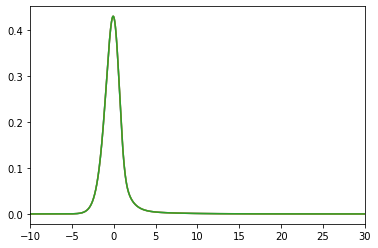

48.32930238571752
Successful convergence to the desired precision after 1191 iterations


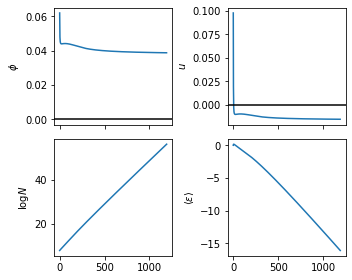

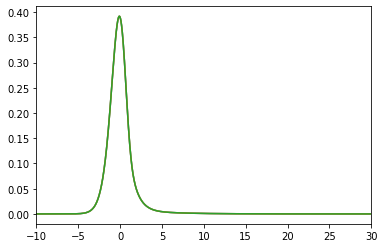

78.47599703514611
Successful convergence to the desired precision after 1464 iterations


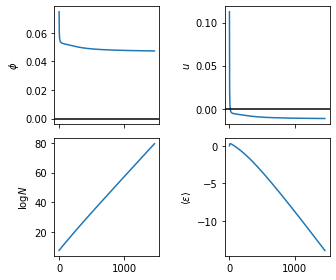

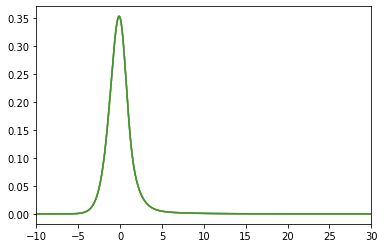

127.42749857031335
Successful convergence to the desired precision after 1812 iterations


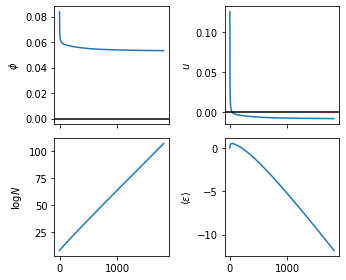

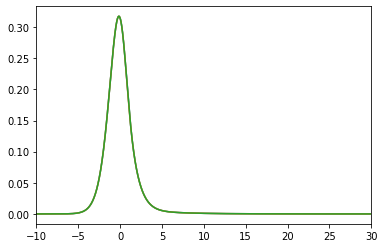

206.913808111479
Successful convergence to the desired precision after 2274 iterations


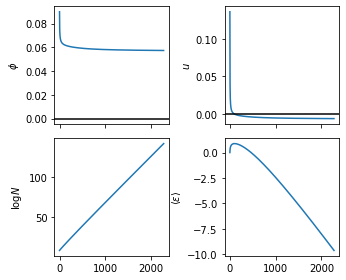

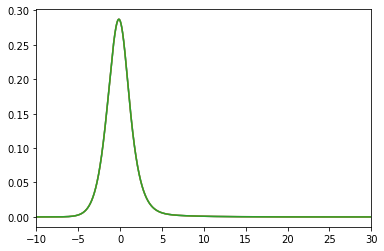

335.9818286283781
Successful convergence to the desired precision after 2927 iterations


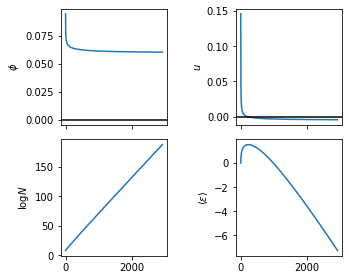

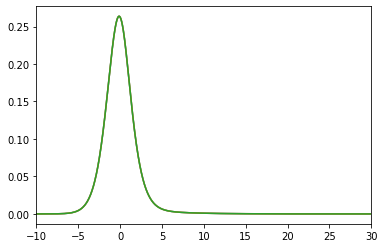

545.5594781168514
Successful convergence to the desired precision after 3933 iterations


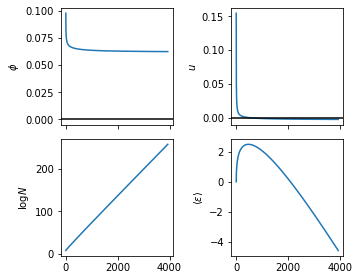

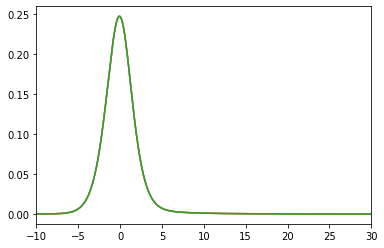

885.8667904100823
Successful convergence to the desired precision after 820 iterations


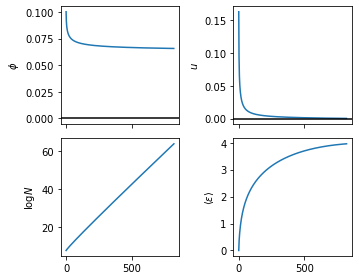

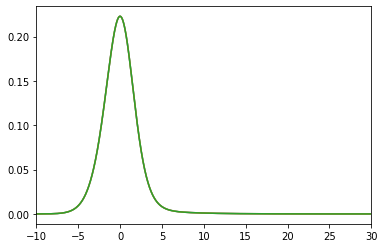

1438.449888287663
Successful convergence to the desired precision after 872 iterations


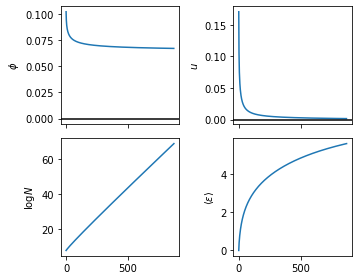

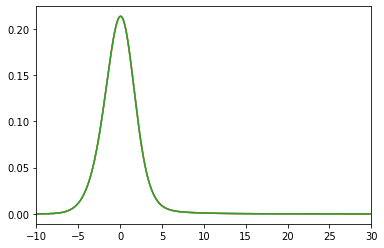

2335.7214690901214
Successful convergence to the desired precision after 936 iterations


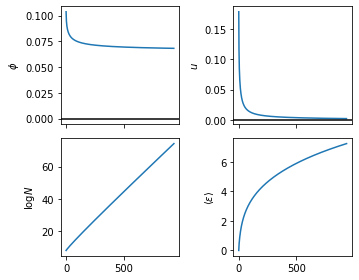

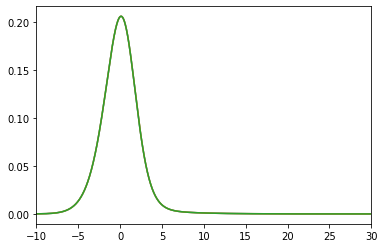

3792.690190732246
Successful convergence to the desired precision after 1009 iterations


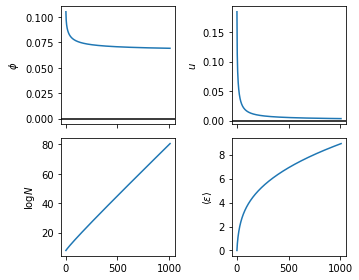

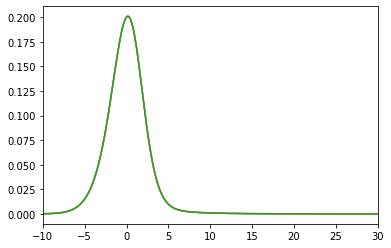

6158.48211066026
Successful convergence to the desired precision after 1083 iterations


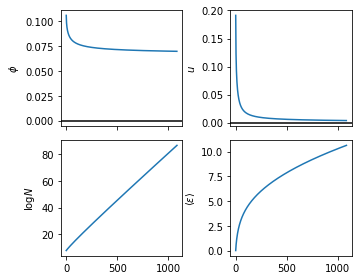

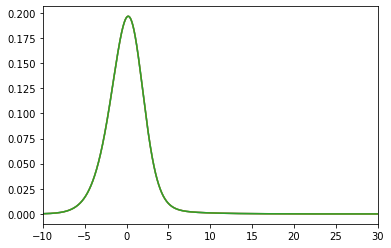

10000.0
Successful convergence to the desired precision after 1155 iterations


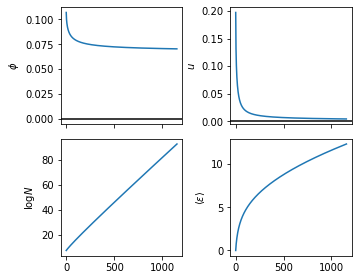

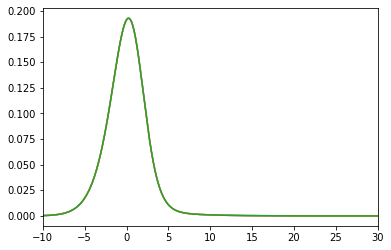

In [6]:
phi_list = []
u_list = []
for C in C_range:
    print(C)
    phi, u = asymptotic_phi_and_u(C, par, T_max_sim)
    phi_list.append(phi)
    u_list.append(u)

In [7]:
# save results
with open('figures/fig_4/phi_u_results.pkl', 'wb') as f:
    pkl.dump([phi_list, u_list], f)
    f.close()
    

# load results
with open('figures/fig_4/phi_u_results.pkl', 'rb') as f:
    phi_list, u_list = pkl.load(f)
    f.close()

In [8]:
# find the two critical concentrations
import scipy.optimize as spo
import scipy.interpolate as spi

log_C = np.log(C_range)

interp_phi = spi.interp1d(log_C, phi_list, bounds_error=True)
log_Cs = spo.brentq(interp_phi, log_C.min(), log_C.max())
interp_u = spi.interp1d(log_C, u_list, bounds_error=True)
log_Css = spo.brentq(interp_u, log_C.min(), log_C.max())

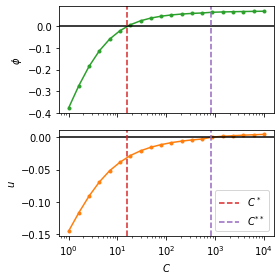

In [9]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(4,4))

ax[0].plot(C_range, phi_list, 'C2.-')
ax[1].plot(C_range, u_list, 'C1.-')

for ax_i in ax:
    # for both axes draw an horizontal line on zero
    ax_i.axhline(0, c='k')
    # and draw two vertical axes at the critical concentrations
    ax_i.axvline(np.exp(log_Cs), c='C3', ls='--',label=r'$C^*$')
    ax_i.axvline(np.exp(log_Css), c='C4', ls='--', label=r'$C^{**}$')

# labels
ax[0].set_ylabel(r'$\phi$')
ax[1].set_ylabel(r'$u$')
ax[1].set_xlabel(r'$C$')
ax[1].legend()

# set logarithmic scale on concentration
plt.xscale('log')

plt.tight_layout()

plt.savefig('figures/fig_4/panel_B.pdf')
plt.savefig('figures/fig_4/panel_B.svg')
plt.show()

In [10]:
import copy

def asymptotic_phi_and_u(C, par, T_max):

    par_cpy = copy.deepcopy(par)
    
    # extend simulation domain and change discretization
    par_cpy['xlim_minus'] = -100
    par_cpy['xlim_plus'] = 100
    par_cpy['dx'] = 0.05
    
    # simulate evolution
    res = evolve_pop_constant_C(C, par_cpy, T_skip=0, T_save=T_max)
    
    t, N, avg_eps, vp, x= [res[lab] for lab in ['t', 'N', 'avg_eps', 'distr_y', 'distr_x']]
    
    # evaluate speed and drift 
    u = np.gradient(avg_eps)
    phi = np.gradient(np.log(N))
    
    # check that u and phi converged to ad least the specified precision
    sensitivity = 1e-4
    u_relative_update = (u[-1] - u[-2])/ u[-1]
    phi_relative_update = (phi[-1] - phi[-2])/ phi[-1]
    if u_relative_update > sensitivity or phi_relative_update > sensitivity:
        print('warning, specified relative update sensitivity not reached:')
        print('u relative update :', u_relative_update)
        print('phi relative update :', phi_relative_update)        
    
    # check that the distribution is not close to the boundaries of the domain
    sigma_min_distance = 3 
    sigma_f = np.sqrt(np.dot(np.square(x - avg_eps[-1]), vp[-1])*par['dx'])
    avg_eps_f = avg_eps[-1]
    sigma_dist_left = (avg_eps_f - par_cpy['xlim_minus'])/sigma_f
    sigma_dist_right = (par_cpy['xlim_plus'] - avg_eps_f)/sigma_f
    if sigma_dist_left < sigma_min_distance or sigma_dist_right < sigma_min_distance:
        print('warning, the final distribution is close to the domain limits:')
        print('left distance in sigmas :', sigma_dist_left)
        print('right distance in sigmas :', sigma_dist_right)
    
    # check convergence precision: L2 norm between the two last distributions recentered
    

    # plot to remove
    fig, ax = plt.subplots(2,2)
    ax[0,0].plot(phi)
    ax[0,1].plot(u)
    ax[1,0].plot(np.log(N))
    ax[1,1].plot(avg_eps)
    plt.show()
    
    # plot to remove
    for idx in range(len(t))[::1]:
        plt.plot(x, vp[idx], c='k')
    #plt.yscale('log')
    plt.xlim(-50,10)
    plt.show()

    
    return phi[-1], u[-1]